# **NLP Project - Sentiment Analysis of Urdu Tweets using Transformers**

## **Mounting Google Drive in Colab Notebook**

First, we will mount Google Drive, where we will upload the dataset so that we don't have to upload it repeatedly every time we run the code.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Libraries**

In the first step/phase of this project, we will install and import the required libraries that are going to be useful in the upcoming step.

### **Installing Required Libraries**

In [1]:
!pip install transformers datasets sentencepiece sacremoses torch --quiet
!pip install pandas scikit-learn openpyxl --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### **Importing Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

## **Dataset**

In the second phase of this project, we are going to load the dataset into Google Colab from Google Drive.

### **Loading the Dataset**

In [ ]:
# Defining the path to the Dataset (Excel file) in Google Drive
file_path = "/content/drive/MyDrive/NLP_Project_Colab/Urdu Tweets Dataset.xlsx"

# Loading the Excel file and reading both the sheets
xls = pd.ExcelFile(file_path)
df1 = pd.read_excel(xls, sheet_name=0)
df2 = pd.read_excel(xls, sheet_name=1)

# Concatenating the two DataFrames
df = pd.concat([df1, df2], ignore_index=True)

print("Combined Dataset Shape:", df.shape)
df.head()

Combined Dataset Shape: (1140823, 5)


,Id,Text,Emotions,Category,Emoticon
0,1313165582020349952,.Assalam Alikum 🦋😊 اے ایمان والو میرے دشم...,"['SMILING FACE WITH SMILING EYES , 0.644']",Joy,NaN
1,1314653586509488128,- '' 🍀 🌾 🌴 '' - ﺍﮬﺪِﻧَﺎﻟﺼِّﺮَﺍﻁَ ﺍَﻟﻤُﺴﺘَﻘِﯿﻢ...,"['HEAVY BLACK HEART , 0.746', 'SPARKLES , 0.35...",NaN,NaN
2,1311404383071067904,💕 میں نہیں کرتی اُس کا ذکر کسی تیسرے کے سات...,"['TWO HEARTS , 0.632']",NaN,NaN
3,1313508198876433920,.🌿.. ﴿کے میشود تمامِ جـهان سـوےِ کربـلا با ک...,"['HERB , 0.384']",NaN,NaN
4,1313510191405596928,.🌿.. ﴿کے میشود تمامِ جـهان سـوےِ کربـلا با ک...,"['HERB , 0.384']",NaN,NaN


## **Data Preprocessing**

In this phase/step of this project, we are going to explore the dataset and do preprocessing on it. We are going to clean the text and map the sentiment categories to the numeric values.

### **Data Exploration and Preprocessing**

In [ ]:
# 1. Checking unique sentiment categories before cleaning
print("Unique sentiment categories (raw):", df['Category'].unique())

# 2. Cleaning the text: removing extra spaces, unwanted characters, etc.
def clean_text(text):
    return " ".join(str(text).split())

df['Text'] = df['Text'].apply(clean_text)

# 3. Define a mapping function to simplify the raw categories into three classes
def map_category(cat):
    cat = str(cat).strip().lower()
    positive_keywords = ['joy', 'happy', 'delight', 'smile']
    negative_keywords = ['anger', 'sad', 'fear', 'disgust']

    if any(word in cat for word in positive_keywords):
        return 'positive'
    elif any(word in cat for word in negative_keywords):
        return 'negative'
    else:
        return 'neutral'

# 4. Apply the mapping function to create a new column for simplified sentiment categories
df['mapped_category'] = df['Category'].apply(map_category)

# 5. Check the unique values after mapping
print("Unique sentiment categories (mapped):", df['mapped_category'].unique())

# 6. Create a mapping from labels to numeric IDs
unique_labels = df['mapped_category'].dropna().unique().tolist()
label2id = {label: idx for idx, label in enumerate(sorted(unique_labels))}
id2label = {idx: label for label, idx in label2id.items()}
print("Mapped Label mapping:", label2id)

# 7. Create a new column for numeric labels using the mapped categories
df['label'] = df['mapped_category'].map(label2id)

df.head()

Unique sentiment categories (raw): [' Joy' nan 'Joy , Joy' ' Sad' 'Disgust , ' 'Fear , ' 'Disgust , Joy'
 'Angry, Disgust , Joy' ' Joy, Sad' ' Surprice' 'Disgust, Joy , Joy'
 'Fear , Joy' 'Sad, Surprice' 'Angry' 'Disgust , Sad' 'Angry , Sad'
 'Angry, Joy , Joy, Sad' 'Fear , Sad' 'Disgust, Joy , Joy, Sad'
 'Disgust , Joy, Sad' 'Sad' 'Joy , Joy, Sad' 'Angry , Joy'
 'Disgust, Joy , Joy, Surprice' 'Fear , Surprice' ' Joy, Sad, Surprice'
 'Disgust, Fear, Joy , Joy' ' Joy, Surprice' 'Fear , Joy, Sad'
 'Joy , Joy, Surprice' 'Disgust, Fear , Joy' 'Angry, Disgust , '
 'Fear, Joy , Joy' 'Disgust , Surprice' 'Angry, Fear , '
 'Disgust, Fear , ' 'Fear , Sad, Surprice' 'Disgust , Sad, Surprice'
 'Angry, Joy , Joy' 'Angry , Joy, Sad' 'Fear, Joy , Joy, Surprice'
 'Angry, Disgust, Joy , Joy, Sad' 'Fear , Joy, Surprice'
 'Angry , Surprice' 'Disgust, Joy , Sad' 'Angry, Disgust , Surprice'
 'Angry , Joy, Surprice' 'Fear, Joy , Joy, Sad' 'Angry, Fear , Sad'
 'Disgust , Joy, Surprice' 'Angry, Joy , Joy, Su

,Id,Text,Emotions,Category,Emoticon,mapped_category,label
0,1313165582020349952,.Assalam Alikum 🦋😊 اے ایمان والو میرے دشمنوں ا...,"['SMILING FACE WITH SMILING EYES , 0.644']",Joy,NaN,positive,2
1,1314653586509488128,- '' 🍀 🌾 🌴 '' - ﺍﮬﺪِﻧَﺎﻟﺼِّﺮَﺍﻁَ ﺍَﻟﻤُﺴﺘَﻘِﯿﻢَ...,"['HEAVY BLACK HEART , 0.746', 'SPARKLES , 0.35...",NaN,NaN,neutral,1
2,1311404383071067904,💕 میں نہیں کرتی اُس کا ذکر کسی تیسرے کے ساتھ ا...,"['TWO HEARTS , 0.632']",NaN,NaN,neutral,1
3,1313508198876433920,.🌿.. ﴿کے میشود تمامِ جـهان سـوےِ کربـلا با کار...,"['HERB , 0.384']",NaN,NaN,neutral,1
4,1313510191405596928,.🌿.. ﴿کے میشود تمامِ جـهان سـوےِ کربـلا با کار...,"['HERB , 0.384']",NaN,NaN,neutral,1


Checking the Distribution of Sentiment Labels

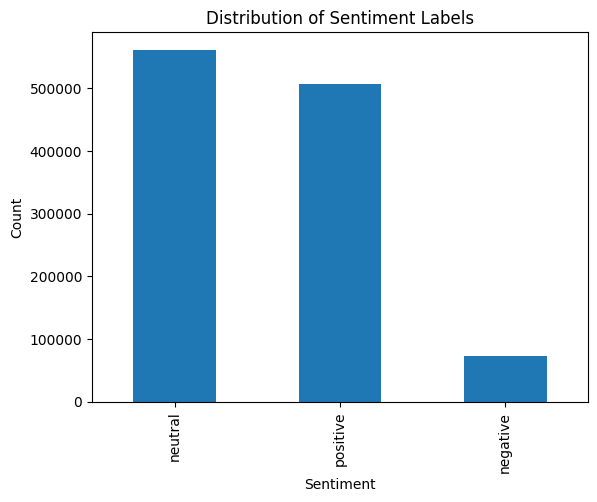

In [ ]:
# Checking the distribution of mapped categories
df['mapped_category'].value_counts().plot(kind='bar')
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

Since the size of the Dataset is too large, nearly 1140823 (1.1 Million) Tweets, the processing on this large dataset will require a lot of resources, so we decided to only use 10% of the Dataset, which comes out to 114082 (114K) tweets.

In [ ]:
# Decide if you need balancing
# Example: Balanced 10% subset

total_size = len(df)
target_size = int(0.1 * total_size)  # 10% of the entire dataset
num_classes = 3  # negative, neutral, positive
subset_per_class = target_size // num_classes

print(f"Total dataset size: {total_size}")
print(f"10% target size: {target_size}")
print(f"Per-class subset: {subset_per_class}")

Total dataset size: 1140823
10% target size: 114082
Per-class subset: 38027


### **Balancing the Dataset**

In [ ]:
# Splitting dataset by classes
df_neg = df[df['mapped_category'] == 'negative']
df_neu = df[df['mapped_category'] == 'neutral']
df_pos = df[df['mapped_category'] == 'positive']

In [ ]:
# Sampling each class
df_neg_subset = df_neg.sample(n=subset_per_class, random_state=42)
df_neu_subset = df_neu.sample(n=subset_per_class, random_state=42)
df_pos_subset = df_pos.sample(n=subset_per_class, random_state=42)

In [ ]:
# Combining & shuffling
df_subset_balanced = pd.concat([df_neg_subset, df_neu_subset, df_pos_subset], ignore_index=True)
df_subset_balanced = df_subset_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced subset shape:", df_subset_balanced.shape)
print(df_subset_balanced['mapped_category'].value_counts())

Balanced subset shape: (114081, 7)
mapped_category
negative    38027
neutral     38027
positive    38027
Name: count, dtype: int64


In [ ]:
# Optionally proceed with df_subset_balanced for training
df_final = df_subset_balanced.copy()

## **Converting the DataFrame to a Hugging Face Dataset and Splitting it**

In [ ]:
# Convert df_final (the balanced subset) into a Hugging Face dataset, split into train/val/test, etc.
from datasets import Dataset, DatasetDict

dataset = Dataset.from_pandas(df_final[['Text', 'label']])
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)  # 80/20 split

test_val_split = split_dataset['test'].train_test_split(test_size=0.5, seed=42)  # 10% val, 10% test
dataset_dict = DatasetDict({
    'train': split_dataset['train'],
    'validation': test_val_split['train'],
    'test': test_val_split['test']
})

print(dataset_dict)
# Then proceed with tokenization, model training, etc.

DatasetDict({
    train: Dataset({
        features: ['Text', 'label'],
        num_rows: 91264
    })
    validation: Dataset({
        features: ['Text', 'label'],
        num_rows: 11408
    })
    test: Dataset({
        features: ['Text', 'label'],
        num_rows: 11409
    })
})


Again checking the Distribution of Sentiment Labels

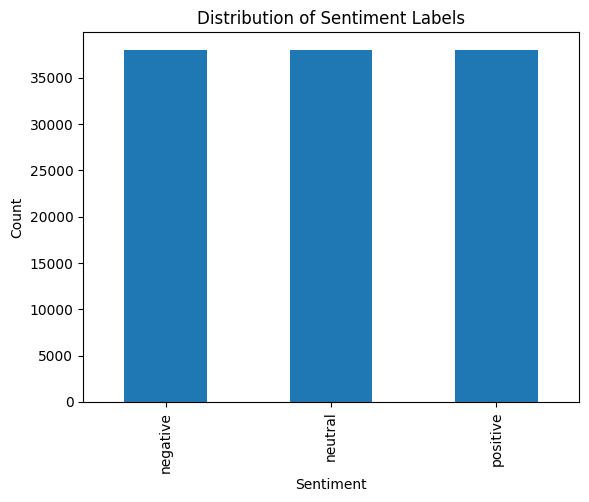

In [ ]:
df_final['mapped_category'].value_counts().plot(kind='bar')
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

## **Tokenization**

In [ ]:
# Choosing the pretrained transformer model
# XLM-Roberta is a Multilingual transformer which supports Urdu Language
model_name = "xlm-roberta-base"

# Loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenizing the text in the dataset
def tokenize_function(example):
    return tokenizer(example["Text"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

# Remove the specified columns only if they exist
columns_to_remove = [col for col in ["Text", "__index_level_0__"] if col in tokenized_datasets.column_names]
tokenized_datasets = tokenized_datasets.remove_columns(columns_to_remove)
tokenized_datasets.set_format("torch")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/91264 [00:00<?, ? examples/s]

Map:   0%|          | 0/11408 [00:00<?, ? examples/s]

Map:   0%|          | 0/11409 [00:00<?, ? examples/s]

**Loading the Pretrained Model**

In [ ]:
num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Defining the Compute Metrics Function**

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    # Generating confusion matrix (for later visualization)
    cm = confusion_matrix(labels, predictions)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm.tolist()  # Convert to list for JSON serialization
    }

**Setting up Training Arguments and Data Collator**

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",  # disable wandb logging if not needed
    bf16=True        # Enable mixed precision training
)

# Creating a data collator that dynamically pads the inputs to the maximum length in the batch
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**Initializing the Trainer and Train the Model**

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Starting training
trainer.train()

<ipython-input-19-41232baf5d62>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,0.061100,0.070527,0.981329,0.981725,0.981329,0.981273,"[[3778, 4, 1], [14, 3848, 14], [32, 148, 3569]]"


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,0.061100,0.070527,0.981329,0.981725,0.981329,0.981273,"[[3778, 4, 1], [14, 3848, 14], [32, 148, 3569]]"
2,0.062600,0.061679,0.981417,0.981792,0.981417,0.981364,"[[3777, 4, 2], [14, 3847, 15], [30, 147, 3572]]"


TrainOutput(global_step=11408, training_loss=0.08857979430055551, metrics={'train_runtime': 6886.203, 'train_samples_per_second': 26.506, 'train_steps_per_second': 1.657, 'total_flos': 1.2006391477764096e+16, 'train_loss': 0.08857979430055551, 'epoch': 2.0})

**Evaluating the Model on the Test Dataset**

In [ ]:
eval_results = trainer.evaluate(tokenized_datasets["test"])
print("Evaluation Results:")
print(eval_results)

# Creating a detailed classification report using scikit-learn:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions, axis=-1)
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(labels, preds, target_names=[id2label[i] for i in range(num_labels)]))

Evaluation Results:
{'eval_loss': 0.055361080914735794, 'eval_accuracy': 0.9815934788325007, 'eval_precision': 0.9820582593501493, 'eval_recall': 0.9815934788325007, 'eval_f1': 0.9815502283126789, 'eval_confusion_matrix': [[3812, 2, 3], [10, 3830, 13], [19, 163, 3557]], 'eval_runtime': 120.5583, 'eval_samples_per_second': 94.635, 'eval_steps_per_second': 5.922, 'epoch': 2.0}
Classification Report:
              precision    recall  f1-score   support

    negative       0.99      1.00      1.00      3817
     neutral       0.96      0.99      0.98      3853
    positive       1.00      0.95      0.97      3739

    accuracy                           0.98     11409
   macro avg       0.98      0.98      0.98     11409
weighted avg       0.98      0.98      0.98     11409



**Saving the Model and Tokenizer**

In [ ]:
save_directory = "/content/drive/MyDrive/NLP_Project_Colab/Trained Model/Urdu_Sentiment_Analysis_Model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
print("Model and tokenizer saved to", save_directory)

Model and tokenizer saved to /content/drive/MyDrive/NLP_Project_Colab/Trained Model/Urdu_Sentiment_Analysis_Model


## **Inference Function**

In [ ]:
def predict_sentiment(tweet):
    # Preprocessing the tweet
    tweet_clean = clean_text(tweet)
    inputs = tokenizer(tweet_clean, return_tensors="pt", truncation=True, padding="max_length", max_length=128)

    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    return id2label[predicted_class]

# Example usage:
sample_tweet = "السلام علیکم! آج کا دن بہت خوبصورت ہے۔"
print("Predicted sentiment:", predict_sentiment(sample_tweet))

Predicted sentiment: neutral


Checking if the model is saved in the directory or not.

In [ ]:
!ls "/content/drive/MyDrive/NLP_Project_Colab/Trained Model/Urdu_Sentiment_Analysis_Model"

config.json	   sentencepiece.bpe.model  tokenizer_config.json
model.safetensors  special_tokens_map.json  tokenizer.json


## **Model Evaluation**

In [ ]:
# Example: If you used Hugging Face Datasets
test_dataset = dataset_dict["test"]  # The test split

# Convert them to lists if needed
test_texts = test_dataset["Text"]
test_labels = test_dataset["label"]

In [ ]:
# Suppose your model returns "negative", "neutral", or "positive"
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}

y_pred = []
for txt in test_texts:
    predicted_label = predict_sentiment(txt)  # e.g. "negative"
    numeric_label = label_mapping[predicted_label]  # convert to 0
    y_pred.append(numeric_label)


In [ ]:
y_true = test_labels

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
print("Confusion Matrix:")
print(cm)

# classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"]))

Confusion Matrix:
[[3812    2    3]
 [  10 3830   13]
 [  19  163 3557]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.99      1.00      1.00      3817
     neutral       0.96      0.99      0.98      3853
    positive       1.00      0.95      0.97      3739

    accuracy                           0.98     11409
   macro avg       0.98      0.98      0.98     11409
weighted avg       0.98      0.98      0.98     11409



              precision    recall  f1-score   support

    negative       0.99      1.00      1.00      3817
     neutral       0.96      0.99      0.98      3853
    positive       1.00      0.95      0.97      3739

    accuracy                           0.98     11409
   macro avg       0.98      0.98      0.98     11409
weighted avg       0.98      0.98      0.98     11409



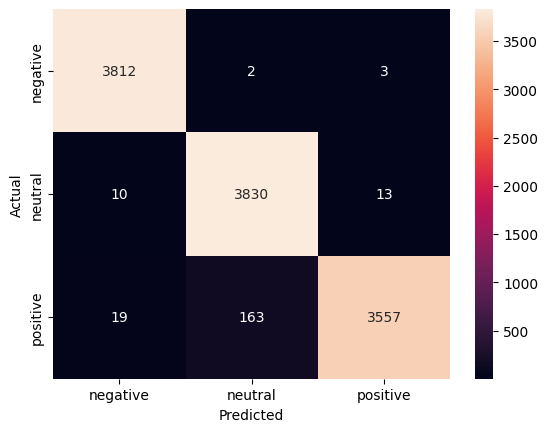

میں بہت غمگین ہوں، دل بہت دکھ رہا ہے۔ -> neutral
آج کا دن بہت خوشگوار گزرا، دل خوش ہو گیا! -> neutral
میٹنگ آج پانچ بجے طے شدہ ہے۔ -> neutral


In [ ]:
# 1. Evaluate on a Balanced Test Set
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose you have a balanced test dataset: test_texts, test_labels
# Convert them to predictions using your trained model
preds = []
for txt in test_texts:
    preds.append(predict_sentiment(txt))  # Your inference function

# Convert string labels back to numeric if needed, or vice versa
# E.g., label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
preds_numeric = [label_mapping[p] for p in preds]

# 2. Classification Report
print(classification_report(test_labels, preds_numeric, target_names=["negative", "neutral", "positive"]))

# 3. Confusion Matrix
cm = confusion_matrix(test_labels, preds_numeric, labels=[0,1,2])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. Known Examples
examples = [
    "میں بہت غمگین ہوں، دل بہت دکھ رہا ہے۔",  # negative
    "آج کا دن بہت خوشگوار گزرا، دل خوش ہو گیا!",  # positive
    "میٹنگ آج پانچ بجے طے شدہ ہے۔"  # neutral
]
for ex in examples:
    print(ex, "->", predict_sentiment(ex))
